In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from poker_embeddings.models.card import CardGNN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CardGNN().to(device)
model.load_state_dict(torch.load("../model_weights/hand_strength_predictor500.pth", weights_only=True))

<All keys matched successfully>

In [3]:
train_losses = pd.read_csv("../results/hand_rank_predictor_train_loss500.csv")
report = pd.read_csv("../results/hand_rank_predictor_classification_report500.csv")
cm = pd.read_csv("../results/hand_rank_predictor_confusion_matrix500.csv")

<Axes: xlabel='epochs', ylabel='train_accuracy'>

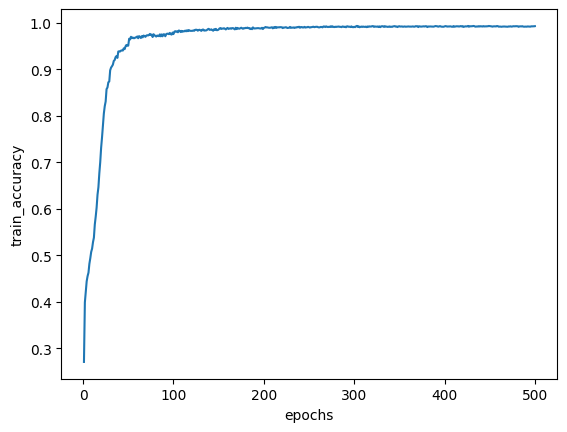

In [7]:

sns.lineplot(data=train_losses, x='epochs',y='train_accuracy')

In [8]:
print(report)

         Unnamed: 0  precision    recall  f1-score        support
0           nothing   0.999915  0.991418  0.995649  308221.000000
1          one_pair   0.999884  0.992015  0.995934  259858.000000
2          two_pair   0.999761  0.998601  0.999180   29297.000000
3   three_of_a_kind   0.999383  0.998998  0.999191   12980.000000
4          straight   0.331919  0.982824  0.496245    2387.000000
5             flush   0.986323  0.996748  0.991508    1230.000000
6        full_house   0.995449  0.998858  0.997151     876.000000
7    four_of_a_kind   0.993007  1.000000  0.996491     142.000000
8    straight_flush   0.727273  0.800000  0.761905      10.000000
9       royal_flush   0.444444  0.800000  0.571429       5.000000
10         accuracy   0.992158  0.992158  0.992158       0.992158
11        macro avg   0.847736  0.955946  0.880468  615006.000000
12     weighted avg   0.997246  0.992158  0.994061  615006.000000


In [3]:
import torch.optim as optim

In [13]:
cm.iloc[:,1:]

,High Card,Pair,Two Pair,Three of a Kind,Straight,Flush,Full House,Four of a Kind,Straight Flush,Royal Flush
0,305576,11,0,0,2634,0,0,0,0,0
1,2,257783,5,1,2053,14,0,0,0,0
2,0,7,29256,3,28,0,3,0,0,0
3,0,0,1,12967,7,0,1,0,0,4
4,24,12,1,4,2346,0,0,0,0,0
5,0,0,0,0,0,1226,0,0,3,1
6,0,0,0,0,0,0,875,1,0,0
7,0,0,0,0,0,0,0,142,0,0
8,0,0,0,0,0,2,0,0,8,0
9,0,0,0,0,0,1,0,0,0,4


In [ ]:
# model.eval()
# with torch.no_grad():
#     card_embeddings = model.card_embedder.weight
#     card_embeddings = model.card_emb_projector(card_embeddings).cpu()
#     card_embeddings_norm = F.normalize(card_embeddings, p=2, dim=1).numpy()

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

In [ ]:
# tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
# emb_2d = tsne.fit_transform(card_embeddings_norm)

In [12]:
# suit_colors = {
#     0: 'green',    # Clubs
#     1: 'blue',      # Diamonds
#     2: 'red',     # Hearts
#     3: 'black'     # Spades
# }

# colors = [suit_colors[i % 4] for i in range(len(DECK_DICT))]

# # Now plot
# plt.figure(figsize=(6, 6))
# for i, txt in DECK_DICT.items():
#     if i == 52:
#         continue  # skip padding card if you have one
#     plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=suit_colors[i % 4])
#     plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

# plt.title("Card Embedding Visualization Colored by Suit")
# plt.show()

In [11]:
# rank_colors = plt.cm.get_cmap('tab20', 13)

# colors = [rank_colors(i // 4) for i in range(len(DECK_DICT))]

# plt.figure(figsize=(6, 6))
# for i, txt in DECK_DICT.items():
#     if i == 52:
#         continue
#     plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=rank_colors(i // 4))
#     plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

# plt.title("Card Embedding Visualization Colored by Rank")
# plt.show()